In [82]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from string import ascii_lowercase
from itertools import combinations

import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import  GradientBoostingClassifier

from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import random
from datetime import datetime

import torch
from sklearn.model_selection import StratifiedKFold
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from tqdm import tqdm

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [83]:
train_data = pd.read_csv('train.csv',index_col=0)
test_data = pd.read_csv('test.csv',index_col=0)

1. 마키아밸리아 평균 점수 산출 후 나머지 문항 삭제

In [84]:
Q_data = train_data.filter(regex='Q',axis=1)
Q_data

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26
index,,,,,,,,,,,,,,,,,,,,,
0,1.0,5.0,5.0,5.0,1.0,4.0,5.0,5.0,1.0,3.0,...,5.0,1.0,5.0,5.0,1.0,5.0,1.0,5.0,1.0,1.0
1,4.0,4.0,4.0,4.0,4.0,5.0,4.0,4.0,3.0,3.0,...,4.0,5.0,1.0,3.0,1.0,1.0,5.0,3.0,2.0,5.0
2,4.0,5.0,5.0,4.0,3.0,5.0,5.0,5.0,4.0,4.0,...,5.0,3.0,5.0,2.0,2.0,1.0,2.0,4.0,2.0,5.0
3,4.0,4.0,4.0,2.0,4.0,3.0,3.0,5.0,3.0,4.0,...,4.0,5.0,4.0,3.0,3.0,4.0,3.0,4.0,4.0,2.0
4,4.0,4.0,4.0,4.0,3.0,3.0,4.0,2.0,3.0,4.0,...,4.0,1.0,4.0,2.0,4.0,2.0,3.0,4.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,2.0,5.0,4.0,3.0,3.0,4.0,4.0,4.0,3.0,4.0,...,2.0,5.0,2.0,4.0,1.0,2.0,5.0,4.0,2.0,4.0
14996,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,5.0,...,5.0,4.0,1.0,5.0,3.0,4.0,4.0,5.0,4.0,5.0
14997,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,...,5.0,5.0,4.0,5.0,5.0,2.0,5.0,5.0,3.0,4.0


In [85]:
train_data['Mach_score'] = Q_data.mean(axis=1)
train_data.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,age,hand,religion,orientation,voted,married,familysize,ASD,nerdiness,Mach_score
index,,,,,,,,,,,,,,,,,,,,,
0,1.0,5.0,5.0,5.0,1.0,4.0,5.0,5.0,1.0,3.0,...,20,2.0,12.0,4.0,2.0,1.0,4.0,2.0,1,3.653846
1,4.0,4.0,4.0,4.0,4.0,5.0,4.0,4.0,3.0,3.0,...,49,1.0,2.0,1.0,1.0,2.0,4.0,2.0,1,3.269231
2,4.0,5.0,5.0,4.0,3.0,5.0,5.0,5.0,4.0,4.0,...,43,1.0,2.0,2.0,2.0,3.0,4.0,2.0,1,3.692308
3,4.0,4.0,4.0,2.0,4.0,3.0,3.0,5.0,3.0,4.0,...,17,2.0,1.0,1.0,2.0,1.0,2.0,2.0,1,3.500000
4,4.0,4.0,4.0,4.0,3.0,3.0,4.0,2.0,3.0,4.0,...,18,2.0,12.0,1.0,2.0,1.0,1.0,2.0,0,3.461538


In [86]:
train_data[['Mach_score']].describe()

,Mach_score
count,14992.000000
mean,3.700245
std,0.584955
min,1.000000
25%,3.346154
50%,3.730769
75%,4.115385
max,5.000000


In [87]:
Q_test_data = test_data.filter(regex='Q',axis=1)
test_data['Mach_score'] = Q_test_data.mean(axis=1)
test_data[['Mach_score']].describe()

,Mach_score
count,35432.000000
mean,3.710776
std,0.577244
min,1.000000
25%,3.346154
50%,3.760000
75%,4.115385
max,5.000000


In [88]:
# Q 데이터 삭제

train_data = train_data[train_data.columns.drop(list(train_data.filter(regex='Q')))]
test_data = test_data[test_data.columns.drop(list(test_data.filter(regex='Q')))]

print(train_data.shape)
print(test_data.shape)

(15000, 44)
(35452, 43)


<AxesSubplot:>

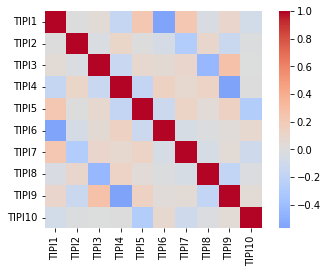

In [89]:
T_data = train_data.filter(regex='TIPI',axis=1)
T_cor = T_data.corr(method='spearman')
sns.heatmap(T_cor, cmap='coolwarm', square=True, center=0)

In [90]:
T_data.head()

,TIPI1,TIPI2,TIPI3,TIPI4,TIPI5,TIPI6,TIPI7,TIPI8,TIPI9,TIPI10
index,,,,,,,,,,
0,4.0,3.0,5.0,1.0,3.0,5.0,5.0,3.0,5.0,3.0
1,4.0,2.0,3.0,5.0,3.0,2.0,5.0,1.0,2.0,2.0
2,1.0,2.0,3.0,1.0,5.0,5.0,3.0,4.0,5.0,2.0
3,3.0,3.0,3.0,4.0,5.0,3.0,4.0,4.0,3.0,3.0
4,3.0,3.0,4.0,4.0,4.0,4.0,3.0,4.0,3.0,2.0


In [91]:
T_data.isnull().sum()

TIPI1     53
TIPI2     66
TIPI3     79
TIPI4     64
TIPI5     70
TIPI6     62
TIPI7     64
TIPI8     65
TIPI9     64
TIPI10    80
dtype: int64

In [92]:
TIPI_col = [col for col in train_data.columns if 'TIPI' in col]
for col in TIPI_col:
    train_data[col] = train_data[col].replace(np.nan, train_data[col].mean())
    test_data[col] = test_data[col].replace(np.nan, test_data[col].mean())
    train_data[col] = 6 - train_data[col]
    test_data[col] = 6 - test_data[col]
    
train_data['TIPI1'].head()

index
0    2.0
1    2.0
2    5.0
3    3.0
4    3.0
Name: TIPI1, dtype: float64

In [93]:
train_data['tp_ex']=(train_data['TIPI1']+5-(train_data['TIPI6']))/2
train_data['tp_ag']=(5-(train_data['TIPI2'])+train_data['TIPI7'])/2
train_data['tp_co']=(train_data['TIPI3']+5-(train_data['TIPI8']))/2
train_data['tp_em']=(5-(train_data['TIPI4'])+train_data['TIPI9'])/2
train_data['tp_op']=(train_data['TIPI5']+5-(train_data['TIPI10']))/2

In [94]:
test_data['tp_ex']=(test_data['TIPI1']+5-(test_data['TIPI6']))/2
test_data['tp_ag']=(5-(test_data['TIPI2']+test_data['TIPI7']))/2
test_data['tp_co']=(test_data['TIPI3']+5-(test_data['TIPI8']))/2
test_data['tp_em']=(5-(test_data['TIPI4']+test_data['TIPI9']))/2
test_data['tp_op']=(test_data['TIPI5']+5-(test_data['TIPI10']))/2

In [95]:
train_data = train_data.drop(columns=TIPI_col,axis=1)
test_data = test_data.drop(columns=TIPI_col,axis=1)

train_data.shape

(15000, 39)

In [96]:
train_data.head()

,country,introelapse,testelapse,surveyelapse,VCL1,VCL2,VCL3,VCL4,VCL5,VCL6,...,married,familysize,ASD,nerdiness,Mach_score,tp_ex,tp_ag,tp_co,tp_em,tp_op
index,,,,,,,,,,,,,,,,,,,,,
0,USA,3,553,6,1,1,0,1,1,0,...,1.0,4.0,2.0,1,3.653846,3.0,1.5,1.5,0.5,2.5
1,USA,5,85,120,1,1,1,1,1,0,...,2.0,4.0,2.0,1,3.269231,1.5,1.0,1.5,4.0,2.0
2,NLD,9,108,100,1,1,0,1,1,0,...,3.0,4.0,2.0,1,3.692308,4.5,2.0,3.0,0.5,1.0
3,USA,2,121,139,1,1,0,1,1,0,...,1.0,2.0,2.0,1,3.500000,2.5,2.0,3.0,3.0,1.5
4,ITA,3,640,216,1,1,0,1,1,0,...,1.0,1.0,2.0,0,3.461538,3.0,2.5,2.5,3.0,1.5


In [97]:
V_effect = ['VCL6','VCL9','VCL12']

for effect_col in V_effect:
    train_data.drop(index = train_data[train_data[effect_col] == 1].index, inplace=True)

In [98]:
train_data = train_data.drop(columns=['country','introelapse','testelapse','surveyelapse','hand','orientation'],axis=1)
test_data = test_data.drop(columns=['country','introelapse','testelapse','surveyelapse','hand','orientation'],axis=1)

train_data.head()

,VCL1,VCL2,VCL3,VCL4,VCL5,VCL6,VCL7,VCL8,VCL9,VCL10,...,married,familysize,ASD,nerdiness,Mach_score,tp_ex,tp_ag,tp_co,tp_em,tp_op
index,,,,,,,,,,,,,,,,,,,,,
0,1,1,0,1,1,0,0,0,0,1,...,1.0,4.0,2.0,1,3.653846,3.0,1.5,1.5,0.5,2.5
1,1,1,1,1,1,0,1,0,0,1,...,2.0,4.0,2.0,1,3.269231,1.5,1.0,1.5,4.0,2.0
2,1,1,0,1,1,0,1,1,0,1,...,3.0,4.0,2.0,1,3.692308,4.5,2.0,3.0,0.5,1.0
3,1,1,0,1,1,0,0,0,0,1,...,1.0,2.0,2.0,1,3.500000,2.5,2.0,3.0,3.0,1.5
4,1,1,0,1,1,0,0,1,0,1,...,1.0,1.0,2.0,0,3.461538,3.0,2.5,2.5,3.0,1.5


In [99]:
#familysize >50 제거
train_data = train_data.drop(train_data[train_data.familysize > 50].index)

In [100]:
train_data.isnull().sum()

VCL1            0
VCL2            0
VCL3            0
VCL4            0
VCL5            0
VCL6            0
VCL7            0
VCL8            0
VCL9            0
VCL10           0
VCL11           0
VCL12           0
VCL13           0
VCL14           0
VCL15           0
VCL16           0
education     125
urban           0
gender         15
engnat         33
age             0
religion      185
voted          66
married        64
familysize    222
ASD            57
nerdiness       0
Mach_score      6
tp_ex           0
tp_ag           0
tp_co           0
tp_em           0
tp_op           0
dtype: int64

In [101]:
# 결측치 제거
train_data.dropna(inplace=True)

In [102]:
train_data.isnull().sum().sum()

0

In [103]:
# 명목형 변수 변환
replace_dict = {'education':str, 'engnat':str, 'married':str, 'urban':str}

train_data = train_data.astype(replace_dict)
test_data = test_data.astype(replace_dict)

# 더미 변수 변한
train_data = pd.get_dummies(train_data)
test_data = pd.get_dummies(test_data)

In [112]:
train_data.shape

(10130, 42)

In [111]:
test_data.shape

(35452, 44)

In [105]:
train_data

,VCL1,VCL2,VCL3,VCL4,VCL5,VCL6,VCL7,VCL8,VCL9,VCL10,...,education_4.0,urban_0,urban_1,urban_2,urban_3,engnat_1.0,engnat_2.0,married_1.0,married_2.0,married_3.0
index,,,,,,,,,,,,,,,,,,,,,
0,1,1,0,1,1,0,0,0,0,1,...,0,0,1,0,0,1,0,1,0,0
1,1,1,1,1,1,0,1,0,0,1,...,1,0,0,1,0,1,0,0,1,0
2,1,1,0,1,1,0,1,1,0,1,...,0,0,1,0,0,0,1,0,0,1
3,1,1,0,1,1,0,0,0,0,1,...,0,0,0,0,1,1,0,1,0,0
4,1,1,0,1,1,0,0,1,0,1,...,0,0,0,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14990,1,0,0,1,0,0,0,0,0,1,...,0,0,1,0,0,0,1,1,0,0
14993,1,1,0,1,1,0,0,0,0,1,...,0,0,0,1,0,1,0,1,0,0
14994,1,1,1,1,1,0,1,0,0,1,...,0,0,0,1,0,1,0,1,0,0


In [113]:
train_data.columns

Index(['VCL1', 'VCL2', 'VCL3', 'VCL4', 'VCL5', 'VCL6', 'VCL7', 'VCL8', 'VCL9',
       'VCL10', 'VCL11', 'VCL12', 'VCL13', 'VCL14', 'VCL15', 'VCL16', 'gender',
       'age', 'religion', 'voted', 'familysize', 'ASD', 'nerdiness',
       'Mach_score', 'tp_ex', 'tp_ag', 'tp_co', 'tp_em', 'tp_op',
       'education_1.0', 'education_2.0', 'education_3.0', 'education_4.0',
       'urban_0', 'urban_1', 'urban_2', 'urban_3', 'engnat_1.0', 'engnat_2.0',
       'married_1.0', 'married_2.0', 'married_3.0'],
      dtype='object')

In [114]:
test_data.columns

Index(['VCL1', 'VCL2', 'VCL3', 'VCL4', 'VCL5', 'VCL6', 'VCL7', 'VCL8', 'VCL9',
       'VCL10', 'VCL11', 'VCL12', 'VCL13', 'VCL14', 'VCL15', 'VCL16', 'gender',
       'age', 'religion', 'voted', 'familysize', 'ASD', 'Mach_score', 'tp_ex',
       'tp_ag', 'tp_co', 'tp_em', 'tp_op', 'education_1.0', 'education_2.0',
       'education_3.0', 'education_4.0', 'education_nan', 'urban_0', 'urban_1',
       'urban_2', 'urban_3', 'engnat_1.0', 'engnat_2.0', 'engnat_nan',
       'married_1.0', 'married_2.0', 'married_3.0', 'married_nan'],
      dtype='object')

In [115]:
test_data = test_data.drop(columns = ['married_nan', 'engnat_nan', 'education_nan'])

In [117]:
from sklearn.model_selection import KFold

X_train = train_data.drop(columns=['nerdiness'], axis=1)
y_train = train_data['nerdiness']
X_test = test_data.copy()

kfold = KFold(n_splits=3, shuffle=True, random_state = 42)
rf = RandomForestClassifier()
lgbm = LGBMClassifier()
gbc = GradientBoostingClassifier()

soft_vote = VotingClassifier([('r1',rf), ('r2',lgbm),('r3',gbc)], voting='soft')
soft_vote.fit(X_train, y_train)

VotingClassifier(estimators=[('r1', RandomForestClassifier()),
                             ('r2', LGBMClassifier()),
                             ('r3', GradientBoostingClassifier())],
                 voting='soft')

In [122]:
test_data.isnull().sum().sum()

1693

In [123]:
X_test = X_test.fillna(X_test.mean())
y_pred = soft_vote.predict(X_test)

submission = pd.DataFrame({'index' :test_data.index, 'nerdiness':y_pred})
submission.to_csv('submission_voting.csv',index=False)